In [76]:
import pandas as pd
import datetime
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from collections import Counter
import pandas as pd
from sklearn.preprocessing import LabelEncoder as le

In [77]:
df_raw = pd.read_excel("output/resampled_df_10_min.xlsx", index_col=[0])

In [78]:
start_date = pd.to_datetime(f"2023-01-10 00:00:00")
end_date = pd.to_datetime(f"2023-05-01 23:50:00")
training_window_size = 30
horizon_size = 7
model_features = ["day", "hour", "weekday", "window_block"] # Day = day of the month (0-31), hour = hour of the day (0-24), weekday = day in the week (0-7), window_block = window block in the hour (0-5)

In [79]:
df = df_raw[df_raw["time"].between(start_date, end_date)].copy()

label_encoder = le()
df.location = label_encoder.fit_transform(df.location)

In [80]:
df["weekday"] = df["time"].dt.dayofweek
df["hour"] = df["time"].dt.hour
df["day"] = df["time"].dt.day
df["window_block"] = ((df['time'].dt.minute * 60 + df['time'].dt.second) // 600).astype(int)


In [81]:
df.head(10)

,time,location,weekday,hour,day,window_block
1,2023-02-01 00:10:00,4,2,0,1,1
2,2023-02-01 00:20:00,4,2,0,1,2
3,2023-02-01 00:30:00,4,2,0,1,3
4,2023-02-01 00:40:00,4,2,0,1,4
5,2023-02-01 00:50:00,4,2,0,1,5
6,2023-02-01 01:00:00,4,2,1,1,0
7,2023-02-01 01:10:00,4,2,1,1,1
8,2023-02-01 01:20:00,4,2,1,1,2
9,2023-02-01 01:30:00,4,2,1,1,3
10,2023-02-01 01:40:00,4,2,1,1,4


In [82]:
train_start_date = start_date
train_end_date = train_start_date + pd.Timedelta(days=training_window_size-1, hours=23, minutes=50)
test_start_date = train_end_date + pd.Timedelta(minutes=10)
test_end_date = test_start_date + pd.Timedelta(days=horizon_size-1, hours=23, minutes=50)

train_mask = df["time"].between(train_start_date, train_end_date)
test_mask = df["time"].between(test_start_date, test_end_date)

# Split the data into train and test sets
X_train = df.loc[train_mask, model_features]
y_train = df.loc[train_mask, "location"]
X_test = df.loc[test_mask, model_features]
y_test = df.loc[test_mask, "location"]

print(f"Training: {train_start_date}-{train_end_date}, testing: {test_start_date}-{test_end_date}.")

Training: 2023-01-10 00:00:00-2023-02-08 23:50:00, testing: 2023-02-09 00:00:00-2023-02-15 23:50:00.


In [83]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Make predictions for 14 days into the future. 
predictions = model.predict(X_test) # Or use predict_proba

In [84]:
print(accuracy_score(y_test, predictions))

0.5396825396825397


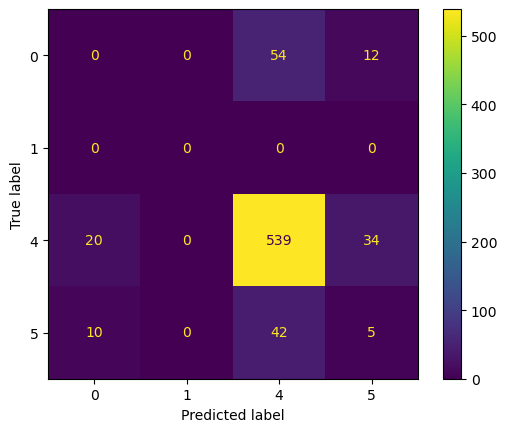

In [85]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, predictions, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

In [87]:
len(predictions)

1008

Message (heatmap visualizer): Making heatmap with 4320 records, starting at 2023-01-10T00:00:00.000000000 and ending at 2023-02-08T23:50:00.000000000.
Message (heatmap visualizer): Succesfully downloaded heatmap to output/heatmap_training.png.
Message (heatmap visualizer): Making heatmap with 2016 records, starting at 2023-02-09T00:00:00.000000000 and ending at 2023-02-22T23:50:00.000000000.
Message (heatmap visualizer): Succesfully downloaded heatmap to output/heatmap_predicted.png.
Message (heatmap visualizer): Making heatmap with 2016 records, starting at 2023-02-09T00:00:00.000000000 and ending at 2023-02-22T23:50:00.000000000.
Message (heatmap visualizer): Succesfully downloaded heatmap to output/heatmap_actual.png.


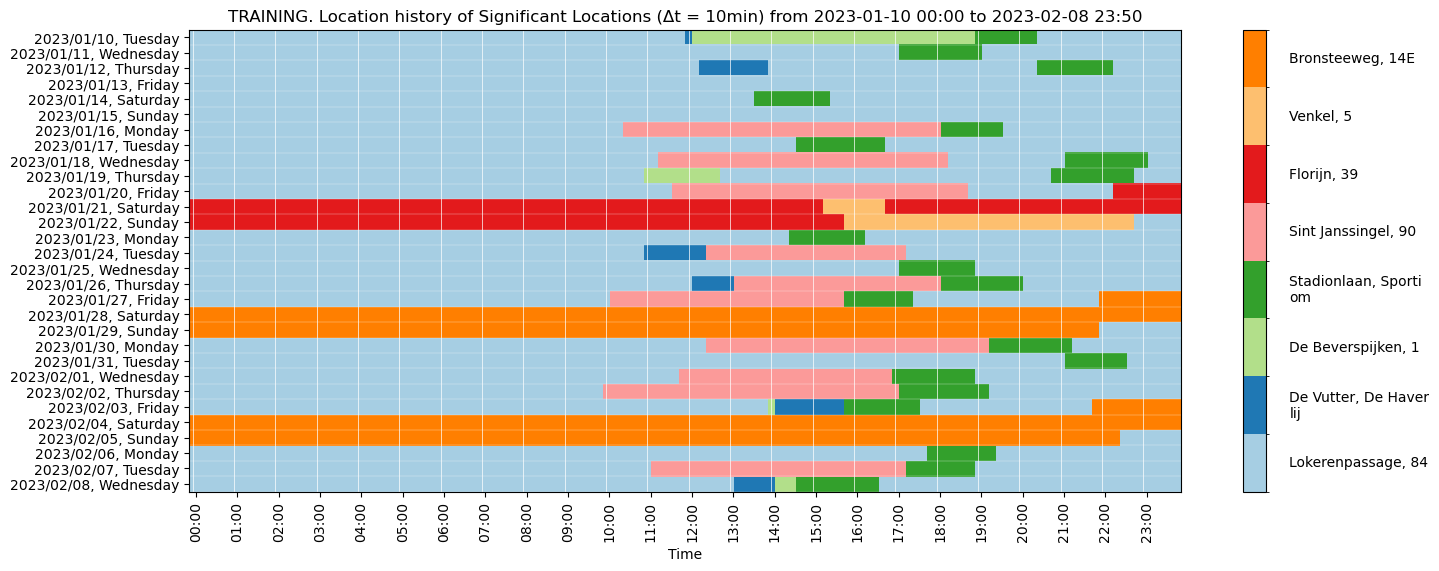

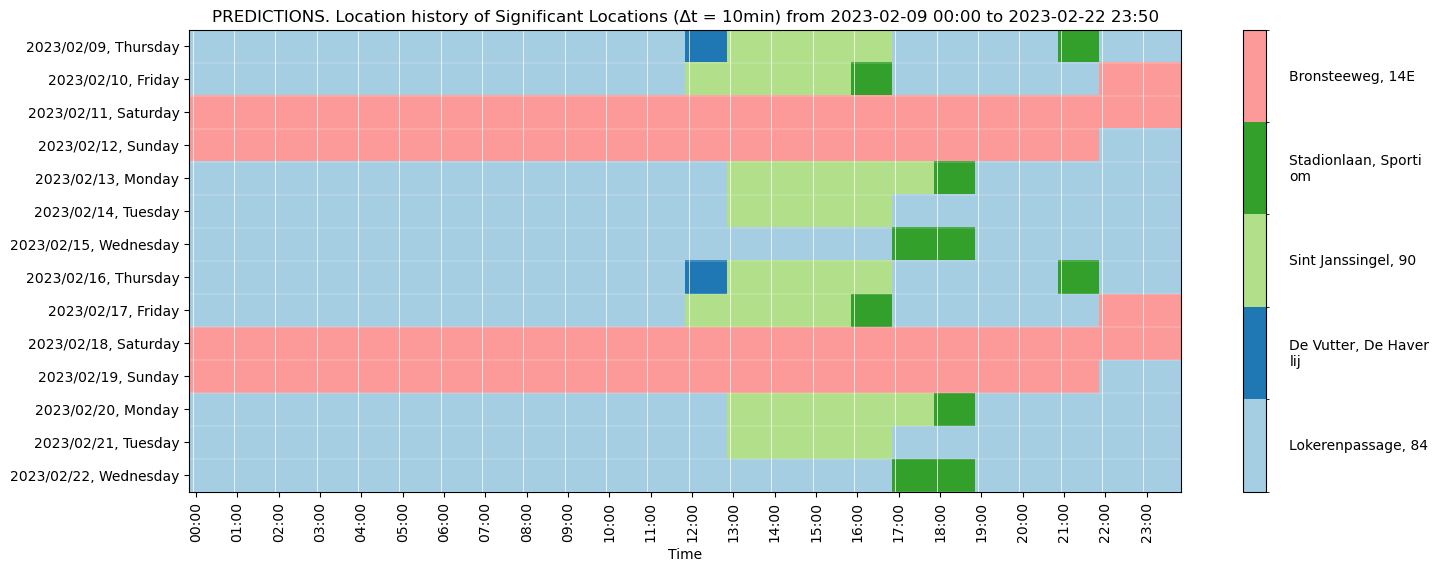

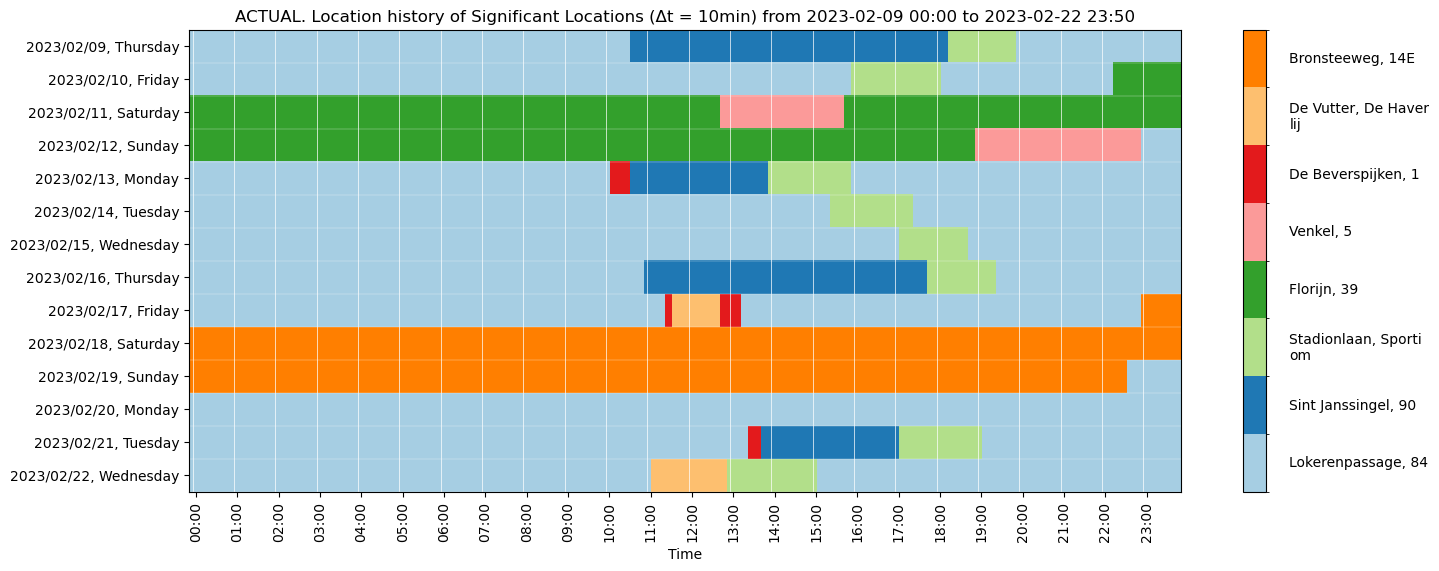

In [74]:
from Visualisations import HeatmapVisualizer


time_intervals = pd.date_range(
    start=test_start_date, end=test_end_date, freq="10T"
)

# Create a DataFrame with the 'time' column and the 'location' column that holds the predicted locations (strings).
df_predictions = pd.DataFrame(
    {
        "time": time_intervals,
        "location": label_encoder.inverse_transform(predictions),
    }
)

HeatmapVisualizer(
    str(train_start_date.date()),
    str(train_end_date.date()),
    df.loc[train_mask][["location", "time"]],  # Now we use the original dataframe (with time and location, 10 min intervals) to visualize the actual data.
    name="heatmap_training",
    title="TRAINING",
)

HeatmapVisualizer(
    str(test_start_date.date()),
    str(test_end_date.date()),
    df_predictions,
    name="heatmap_predicted",
    title="PREDICTIONS",
)

HeatmapVisualizer(
    str(test_start_date.date()),
    str(test_end_date.date()),
    df.loc[test_mask][["location", "time"]],  # Now we use the original dataframe (with time and location, 10 min intervals) to visualize the actual data.
    name="heatmap_actual",
    title="ACTUAL",
)